In [1]:
from pyspark.sql.types import *
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.ml.feature import IndexToString, StringIndexer
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree


In [2]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
percentage = udf(lambda x: x*100/11933, FloatType())

In [4]:
# File location and type
file_location = "/FileStore/tables/DS_Take_Home_Sample_Data___DS_Take_Home_Sample_Data-c561c.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "True"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df.limit(5))

source,campaign,region,locality,preferred_doctor_gender,dental_anxiety,last_visited_a_dentist,how_soon_they_want_to_book,reason_for_visit,patient_insured,number_of_match_results,out_network_results_shown,in_network_results_shown,avg_distance_overall,appointment_requested,appointment_status,appointment_scheduled,appointment_billed,chosen_provider_insurance_status,chosen_provider_distance
facebook,san_diego_dentist_patient_acquisition,San Jose,San Jose,No Pref,A little nervous,< 1 year,ASAP,Specific Treatment,f,9,0,0,10547.21951,f,null,f,null,null,null
facebook,san_diego_dentist_patient_acquisition,San Diego,Chula Vista,F,Not at all nervous,2+ years,2 weeks,Checkup & Cleaning,f,2,0,0,20784.61772,f,null,f,null,null,null
try.opencare.com,Unknown,Austin,Austin,No Pref,Moderately nervous,2+ years,ASAP,Checkup & Cleaning,t,9,8,1,8014.945931,t,CANCELLED,f,f,in-network,2855.594821
facebook,denver_dentist_patient_acquisition,Denver,Golden,No Pref,Not at all nervous,< 1 year,ASAP,Specific Treatment,t,8,2,6,16651.15875,f,null,f,null,null,null
facebook,chicago_dentist_patient_acquisition,Chicago,Chicago,F,Not at all nervous,< 1 year,1 week,Checkup & Cleaning,f,9,0,0,5216.934559,f,null,f,null,null,null
Direct,Unknown,San Francisco,San Francisco,No Pref,Moderately nervous,2+ years,ASAP,Urgent Issue,t,9,8,1,2150.607797,f,null,f,null,null,null
facebook,chicago_dentist_patient_acquisition,Chicago,Hanover Park,F,Not at all nervous,1 - 2 years,2 weeks,Checkup & Cleaning,t,3,2,1,21242.31032,f,null,f,null,null,null
Direct,Unknown,San Francisco,San Francisco,No Pref,Moderately nervous,2+ years,ASAP,Urgent Issue,t,9,5,4,2150.607797,f,null,f,null,null,null
www.opencare.com,Unknown,Seattle,Renton,No Pref,Not at all nervous,1 - 2 years,No preference,Checkup & Cleaning,t,9,3,6,9143.70618,f,null,f,null,null,null
adwords,search_chicago_local,Chicago,Ottawa,No Pref,A little nervous,< 1 year,ASAP,Urgent Issue,t,0,0,0,null,f,null,f,null,null,null


In [5]:
df.groupby('appointment_requested').count().show()

+---------------------+-----+
appointment_requested|count|
+---------------------+-----+
 f| 9148|
 t| 2785|
+---------------------+-----+

In [6]:
df_stratified = df.sampleBy('appointment_requested', fractions={"f": 0.30, "t": 1.0})


In [7]:
categorical_features = ['source' , 'region', 'preferred_doctor_gender', 'dental_anxiety', 'last_visited_a_dentist', 'how_soon_they_want_to_book', 'reason_for_visit', 'number_of_match_results', 'patient_insured', 'out_network_results_shown', 'in_network_results_shown']

normalized_col = [col('avg_distance_overall').cast(DoubleType())]
numerical_features = 'avg_distance_overall'

label = ['appointment_requested' 
          #, 'appointment_billed'
         ]

index_column = categorical_features + label
index_column

selected_cols = categorical_features + numerical_features + label

In [8]:
df_stratified_fill_na = df_stratified.fillna(
  '', index_column
).fillna('0.0' , numerical_feature)

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_stratified_fill_na) for column in  index_column]


pipeline = Pipeline(stages=indexers)
transformed_selected_columns = pipeline.fit(df_stratified_fill_na).transform(df_stratified_fill_na)

In [10]:
avg_distance_overall = df.select(normalized_col).describe().show()

+-------+--------------------+
summary|avg_distance_overall|
+-------+--------------------+
 count| 11363|
 mean| 11059.06672422|
 stddev| 5313.265881404456|
 min| 305.972994|
 max| 24960.20697|
+-------+--------------------+

In [11]:
#normalizing numerical columns
def normalizing_column_1(c , dL, dH):
  nL = 0
  nH = 1
  numi = (float(c) - dL) * (nH-nL)
  denom = dH - dL
  div = float(numi) / float(denom)
  normalized = float(div + nL)
  return normalized

normalizing_column = udf(normalizing_column_1, DoubleType())
dL = 305.972994
dH = 24960.20697

transformed_selected_columns = transformed_selected_columns.withColumn('normalized_' + str('avg_distance_overall'), 
                           normalizing_column(colname, lit(dL) , lit(dH))
                          )                                                                   
    

In [12]:
transformed_selected_columns.select('normalized_avg_distance_overall').describe().show()

+-------+-------------------------------+
summary|normalized_avg_distance_overall|
+-------+-------------------------------+
 count| 5482|
 mean| 0.4117665650258571|
 stddev| 0.22298588028862532|
 min| -0.01241056584024...|
 max| 1.0|
+-------+-------------------------------+

In [13]:
features = ['source_index' , 'region_index', 'preferred_doctor_gender_index', 'dental_anxiety_index', 'last_visited_a_dentist_index', 'how_soon_they_want_to_book_index', 'reason_for_visit_index', 'number_of_match_results_index', 'patient_insured_index', 'out_network_results_shown_index', 'in_network_results_shown_index' , 'normalized_avg_distance_overall']

In [14]:
from pyspark.ml.feature import StringIndexer, VectorIndexer , VectorAssembler
va = VectorAssembler(inputCols=features, outputCol="features")
dataset_assembled = va.transform(transformed_selected_columns)

display(dataset_assembled)

source,campaign,region,locality,preferred_doctor_gender,dental_anxiety,last_visited_a_dentist,how_soon_they_want_to_book,reason_for_visit,patient_insured,number_of_match_results,out_network_results_shown,in_network_results_shown,avg_distance_overall,appointment_requested,appointment_status,appointment_scheduled,appointment_billed,chosen_provider_insurance_status,chosen_provider_distance,source_index,region_index,preferred_doctor_gender_index,dental_anxiety_index,last_visited_a_dentist_index,how_soon_they_want_to_book_index,reason_for_visit_index,number_of_match_results_index,patient_insured_index,out_network_results_shown_index,in_network_results_shown_index,appointment_requested_index,normalized_avg_distance_overall,features
facebook,san_diego_dentist_patient_acquisition,San Jose,San Jose,No Pref,A little nervous,< 1 year,ASAP,Specific Treatment,f,9,0,0,10547.21951,f,null,f,null,null,null,0.0,5.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.4153950402989394,"List(0, 12, List(1, 3, 6, 8, 11), List(5.0, 1.0, 1.0, 1.0, 0.4153950402989394))"
try.opencare.com,Unknown,Austin,Austin,No Pref,Moderately nervous,2+ years,ASAP,Checkup & Cleaning,t,9,8,1,8014.945931,t,CANCELLED,f,f,in-network,2855.594821,4.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,0.3126835311332084,"List(1, 12, List(), List(4.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 8.0, 2.0, 0.3126835311332084))"
facebook,denver_dentist_patient_acquisition,Denver,Golden,No Pref,Not at all nervous,< 1 year,ASAP,Specific Treatment,t,8,2,6,16651.15875,f,null,f,null,null,null,0.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,5.0,1.0,0.6629768246667669,"List(0, 12, List(1, 6, 7, 9, 10, 11), List(4.0, 1.0, 1.0, 2.0, 5.0, 0.6629768246667669))"
www.opencare.com,Unknown,Seattle,Renton,No Pref,Not at all nervous,1 - 2 years,No preference,Checkup & Cleaning,t,9,3,6,9143.70618,f,null,f,null,null,null,3.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,3.0,5.0,1.0,0.35846715799822504,"List(1, 12, List(), List(3.0, 1.0, 0.0, 0.0, 1.0, 4.0, 0.0, 0.0, 0.0, 3.0, 5.0, 0.35846715799822504))"
facebook,austin_dentist_patient_acquisition,Denver,Denver,No Pref,Not at all nervous,1 - 2 years,2 weeks,Checkup & Cleaning,t,9,3,6,6988.795215,t,CANCELLED,f,f,in-network,1586.381633,0.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,5.0,0.0,0.2710618479367676,"List(0, 12, List(1, 4, 5, 9, 10, 11), List(4.0, 1.0, 1.0, 3.0, 5.0, 0.2710618479367676))"
jan_2018_high_offer,jan_2018_high_offer,Seattle,Seattle,No Pref,Not at all nervous,1 - 2 years,2 weeks,Checkup & Cleaning,t,9,6,3,5475.423772,t,COMPLETED,t,t,in-network,2293.225576,13.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6.0,3.0,0.0,0.20967801242708545,"List(1, 12, List(), List(13.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 6.0, 3.0, 0.20967801242708545))"
Direct,Unknown,San Francisco,San Francisco,No Pref,Not at all nervous,< 1 year,More than 2 weeks,Checkup & Cleaning,t,9,1,8,1700.9693,t,CANCELLED,f,f,in-network,150.301854,6.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,9.0,0.0,0.05658242342301035,"List(0, 12, List(0, 1, 5, 9, 10, 11), List(6.0, 3.0, 2.0, 1.0, 9.0, 0.05658242342301035))"
growsumo,Unknown,San Francisco,San Francisco,M,Moderately nervous,1 - 2 years,ASAP,Checkup & Cleaning,t,4,3,1,2393.960273,t,CANCELLED,t,f,in-network,1901.820129,7.0,3.0,2.0,2.0,1.0,0.0,0.0,5.0,0.0,3.0,2.0,0.0,0.08469081947679168,"List(1, 12, List(), List(7.0, 3.0, 2.0, 2.0, 1.0, 0.0, 0.0, 5.0, 0.0, 3.0, 2.0, 0.08469081947679168))"
Patients,Unknown,Denver,Denver,No Pref,Moderately nervous,1 - 2 years,2 weeks,Checkup & Cleaning,t,9,6,3,6988.795215,t,COMPLETED,t,f,out-network,5002.342742,2.0,4.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,6.0,3.0,0.0,0.2710618479367676,"List(1, 12, List(), List(2.0, 4.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 6.0, 3.0, 0.2710618479367676))"
patient_leads_may_2018,patient_leads_may_2018,San Francisco,San Francisco,No Pref,Not at all nervous,< 1 year,More than 2 weeks,Checkup & Cleaning,t,9,1,8,1700.9693,t,COMPLETED,t,f,in-network,150.301854,18.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,9.0,0.0,0.05658242342301035,"List(0, 12, 

In [15]:
dataset_assembled = dataset_assembled.withColumn('label' , col('appointment_requested_index'))

In [16]:
(train , test) = dataset_assembled.randomSplit([0.7, 0.3])

In [17]:
from pyspark.ml.classification import LogisticRegression
logistic_regression = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)


model = logistic_regression.fit(train)
predictions = model.transform(test)

In [18]:
# features = [
'source_index' , # 0.0047
'region_index', # -0.0339
'preferred_doctor_gender_index', # 0.0251
'dental_anxiety_index', # -0.0243
    'last_visited_a_dentist_index', # -0.1582
    'how_soon_they_want_to_book_index', # 0.1493 **
    'reason_for_visit_index', # 0.1849 **
    'number_of_match_results_index', # 0.1324 **
    'patient_insured_index', # 0.4748 ***
'out_network_results_shown_index', # 0.056
'in_network_results_shown_index' , # -0.0303
    'normalized_avg_distance_overall' , # 0.1134 **
#]
feature_importance = model.coefficients
feature_importance

Out[ 119 ]: DenseVector([0.0047, -0.0339, 0.0251, -0.0243, -0.1582, 0.1493, 0.1849, 0.1324, 0.4748, 0.056, -0.0303, 0.1134])

In [19]:
display(predictions.groupby('label', 'probability').count().sort('label', 'probability'))


label,probability,count
0.0,"List(1, 2, List(), List(0.18391086640741758, 0.8160891335925824))",1
0.0,"List(1, 2, List(), List(0.19093656969911726, 0.8090634303008828))",1
0.0,"List(1, 2, List(), List(0.20372744566655332, 0.7962725543334467))",1
0.0,"List(1, 2, List(), List(0.20674010687814354, 0.7932598931218564))",1
0.0,"List(1, 2, List(), List(0.20743629045547235, 0.7925637095445277))",1
0.0,"List(1, 2, List(), List(0.21829527888750497, 0.7817047211124951))",1
0.0,"List(1, 2, List(), List(0.22610420494542904, 0.773895795054571))",1
0.0,"List(1, 2, List(), List(0.2298038938244495, 0.7701961061755505))",1
0.0,"List(1, 2, List(), List(0.23397028787425095, 0.766029712125749))",1
0.0,"List(1, 2, List(), List(0.24942647233585782, 0.7505735276641422))",1


In [20]:
confusion_matrix = predictions.groupBy('label').pivot('prediction').count()
display(confusion_matrix)

label,0.0,1.0
0.0,590,304
1.0,376,456


In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

Out[ 85 ]: 0.6380087334365849

In [22]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from pylab import *


In [23]:
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()

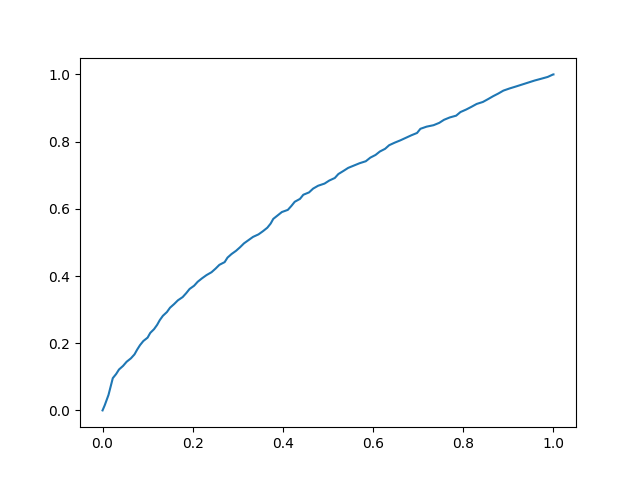

In [24]:
plt.figure(figsize=(1,1))
fig, ax = plt.subplots()
x = roc['FPR']
y = roc['TPR']

ax.plot(x,y)
ax.set_ylim('False Positive Rate')
ax.set_xlim('True Positive Rate')
display(fig)

In [25]:
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Training set areaUnderROC: 0.6307145601501681

In [26]:
within_percentage = udf(lambda x: x*100/1726, FloatType())
predictions.groupby('prediction').count().withColumn('%' , within_percentage('count')).show()

+----------+-----+---------+
prediction|count| %|
+----------+-----+---------+
 0.0| 966|55.967556|
 1.0| 760|44.032444|
+----------+-----+---------+

# Model Post Analysis

In [28]:
display(predictions.withColumn('score', secondelement('probability')).filter(col('label')==1).describe('score'))

summary,score
count,832
mean,0.5247247513885108
stddev,0.11814228129986783
min,0.22006555
max,0.86582226


In [29]:
display(predictions.withColumn('score', secondelement('probability')).filter(col('label')==0).describe('score'))

summary,score
count,894
mean,0.4691533813173872
stddev,0.10709009574775324
min,0.24524565
max,0.81608915


In [30]:
secondelement=udf(lambda v:float(v[1]),FloatType())
bucket_count = 100

In [31]:
display(predictions.withColumn('score', secondelement('probability')).select(
  'label',
  round(col('score')*bucket_count).alias('score_rounded')
).filter(
  (col('score_rounded').isin([0,10,20,30,40,50,60,70,80,90]))
).groupBy(
  'score_rounded',
  'label'
).agg(
  count('*').alias('total')
).sort('score_rounded','label'))

score_rounded,label,total
30.0,0.0,10
30.0,1.0,4
40.0,0.0,27
40.0,1.0,22
50.0,0.0,25
50.0,1.0,36
60.0,0.0,17
60.0,1.0,25
70.0,0.0,1
70.0,1.0,11


In [32]:
def bucket(value): 
  for i in reversed(percentile):
    if value >= i:
      return float(percentile.index(i))
  return -1.0 # not found
  
bucket = udf(bucket, FloatType())

In [33]:
data = predictions.withColumn('score', secondelement('probability'))

bucket_percentiles = []
for i in range(0, bucket_count+1, 1):
  bucket_percentiles.append(i/bucket_count)

percentile = data.approxQuantile('score', bucket_percentiles, 0)

display(data.select(
  'label',
  bucket('score').alias('percentiles')
).groupBy(
  'percentiles',
  'label'
).agg(
  count('*').alias('total')
).sort('percentiles','label'))

percentiles,label,total
0.0,0.0,10
0.0,1.0,7
1.0,0.0,11
1.0,1.0,6
2.0,0.0,14
2.0,1.0,3
3.0,0.0,15
3.0,1.0,3
4.0,0.0,13
4.0,1.0,5


## Gradient Boosted

In [35]:
from pyspark.ml.classification import *
gbt = GBTClassifier(
  maxDepth=2, 
  maxBins=75, 
  minInstancesPerNode=1, 
  minInfoGain=0.0, 
  maxMemoryInMB=256, 
  cacheNodeIds=False, 
  checkpointInterval=10, 
  lossType="logistic", 
  maxIter=200,
  stepSize=0.01, 
  seed=123456789, 
  subsamplingRate=1.0
)


gbt_model = gbt.fit(train)

transformed_testing = gbt_model.transform(test)
evaluator.evaluate(transformed_testing)

Out[ 86 ]: 0.6894924496644295

In [36]:
confusion_matrix = transformed_testing.groupBy('label').pivot('prediction').count()
display(confusion_matrix)

label,0.0,1.0
0.0,565,329
1.0,302,530
